# Exploratory Data Analysis (EDA)

This script performs data checks, descriptive tables and the core visualizations required to understand the monthly Pulmonary Tuberculosis series (2001–2010) and to prepare inputs for time-series modeling and forecasting (2011 prediction).

## Step #1: Initiate environment for **Exploratory Data Analysis**
This section imports necessary libraries, creates debugging flags and control variables and configures paths.

In [1]:
# EN: Setup cell - imports, debug/lang flags, paths, and plotting defaults
# PT-BR: Célula de setup - imports, flags de debug/idioma, caminhos e defaults de plot

DEBUG = True        # EN: Show debug messages?  PT-BR: Mostrar mensagens de debug?
LANGUAGE = "EN"     # EN: "EN" or "PT"  PT-BR: "EN" ou "PT"

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import locale
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot defaults
plt.rcParams.update({"figure.figsize": (12, 5), "font.size": 12})
sns.set_style("whitegrid")

# Paths (adjust if needed)
DATA_DIR = Path("processed_data")
FIG_DIR = Path("figures")
TAB_DIR = Path("tables")
FIG_DIR.mkdir(exist_ok=True, parents=True)
TAB_DIR.mkdir(exist_ok=True, parents=True)

def debug(en_msg, pt_msg=""):
    if not DEBUG:
        return
    msg = en_msg if LANGUAGE.upper()=="EN" else (pt_msg if pt_msg else en_msg)
    print("[DEBUG]", msg)

debug("Setup completed. Data dir = processed_data/", "Setup completo. Pasta de dados = processed_data/")


[DEBUG] Setup completed. Data dir = processed_data/


### Step 2: **Load Data**
Load the preprocessed data for EDA.

In [2]:
# EN: Load core CSVs (already preprocessed)
# PT-BR: Carregar CSVs principais (já pré-processados)

fn_filtered = DATA_DIR / "filtered_pulmonary_tb_rows.csv"
fn_monthly = DATA_DIR / "monthly_pulmonary_tb_by_month.csv"
fn_annual = DATA_DIR / "annual_pulmonary_tb_by_year.csv"

for f in (fn_filtered, fn_monthly, fn_annual):
    if not f.exists():
        raise FileNotFoundError(f"Required file not found: {f} — check pre-processing step. / Arquivo necessário não encontrado: {f} — verifique pré-processamento.")

df_raw = pd.read_csv(fn_filtered, low_memory=False)
df_monthly = pd.read_csv(fn_monthly, parse_dates=["date"] if "date" in pd.read_csv(fn_monthly, nrows=0).columns else None)
df_annual = pd.read_csv(fn_annual)

debug(f"Loaded: filtered={len(df_raw)} rows, monthly={len(df_monthly)} rows, annual={len(df_annual)} rows",
    f"Carregados: filtrados={len(df_raw)} linhas, mensal={len(df_monthly)} linhas, anual={len(df_annual)} linhas")

# Quick peek
df_raw.head()


[DEBUG] Loaded: filtered=26211 rows, monthly=120 rows, annual=10 rows


,nu_notific,tp_not,id_agravo,dt_notific,nu_ano,sg_uf_not,id_municip,id_regiona,id_unidade,dt_diag,...,nu_comu_ex,situa_9_m,situa_12_m,situa_ence,dt_encerra,nu_lote_ia,date_parsed,year,month,cases_raw
0,19210,2.0,A169,2001-10-02,2001.0,21.0,210880.0,1432.0,2645696.0,2001-10-02,...,NaN,2.0,NaN,2.0,2002-02-04 00:00:00,2010001.0,2001-02-10,2001,2,0
1,28158,2.0,A169,2001-01-17,2001.0,21.0,211130.0,1430.0,2464276.0,2000-12-20,...,NaN,1.0,NaN,1.0,2001-07-26 00:00:00,2009022.0,2001-01-17,2001,1,0
2,28142,2.0,A169,2001-04-28,2001.0,21.0,211130.0,1430.0,2698021.0,2001-04-28,...,NaN,1.0,NaN,1.0,2001-10-30 00:00:00,2009022.0,2001-04-28,2001,4,0
3,33044,2.0,A169,2001-07-12,2001.0,21.0,211130.0,1430.0,2458292.0,2001-07-12,...,NaN,4.0,NaN,4.0,2004-10-08 00:00:00,2009022.0,2001-12-07,2001,12,0
4,27490,2.0,A169,2001-01-19,2001.0,21.0,211130.0,1430.0,2458292.0,2001-01-19,...,NaN,2.0,NaN,2.0,2001-05-19 00:00:00,2009022.0,2001-01-19,2001,1,0


### Step 3: **Check Data**
Check the loaded data for errors and inconsistencies.

In [3]:
# EN: Quick sanity checks: dtypes, missing counts, date parse validation
# PT-BR: Checagens rápidas: dtypes, contagem de missings, validação de data

def print_section(title_en, title_pt):
    if LANGUAGE.upper()=="EN":
        print(title_en)
    else:
        print(title_pt)

print_section("=== RAW ROWS: info() ===", "=== LINHAS FILTRADAS: info() ===")
display(df_raw.info())

print_section("\n=== MONTHLY: head() & dtypes ===", "\n=== MENSAL: head() & tipos ===")
display(df_monthly.head())
display(df_monthly.dtypes)

print_section("\n=== Missing values (raw) ===", "\n=== Valores faltantes (raw) ===")
display(df_raw.isna().sum().to_frame("missing_count").sort_values("missing_count", ascending=False).head(40))

print_section("\n=== Missing values (monthly) ===", "\n=== Valores faltantes (mensal) ===")
display(df_monthly.isna().sum().to_frame("missing_count").sort_values("missing_count", ascending=False))


=== RAW ROWS: info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26211 entries, 0 to 26210
Columns: 106 entries, nu_notific to cases_raw
dtypes: float64(74), int64(7), object(25)
memory usage: 21.2+ MB


None


=== MONTHLY: head() & dtypes ===


,year,month,cases,date
0,2001,1,236,2001-01-01
1,2001,2,174,2001-02-01
2,2001,3,219,2001-03-01
3,2001,4,178,2001-04-01
4,2001,5,295,2001-05-01


year              int64
month             int64
cases             int64
date     datetime64[ns]
dtype: object


=== Missing values (raw) ===


,missing_count
dt_transdm,26211
dt_transrm,26211
id_geo2,26211
extrapul_o,26211
id_geo1,26194
situa_12_m,26140
dt_transus,26036
id_cns_sus,26026
id_logrado,25833
agravoutde,25754



=== Missing values (monthly) ===


,missing_count
year,0
month,0
cases,0
date,0


### Step 4: **Check Data Types and Statistics**
Check the loaded data for incompatible data types and extract basic statistics for initial investigation.

In [4]:
# EN: Ensure 'date' is datetime and set monthly index; compute basic descriptive stats for monthly series
# PT-BR: Garantir que 'date' é datetime e definir index mensal; calcular estatísticas descritivas básicas

# Ensure date column:
if "date" in df_monthly.columns:
    df_monthly["date"] = pd.to_datetime(df_monthly["date"], errors="coerce")
else:
    # fallback: construct date if year/month columns exist
    if "year" in df_monthly.columns and "month" in df_monthly.columns:
        df_monthly["date"] = pd.to_datetime(df_monthly["year"].astype(str) + "-" + df_monthly["month"].astype(str) + "-01", errors="coerce")
    else:
        raise SystemExit("Monthly CSV lacks 'date' and no year/month columns — cannot proceed. / CSV mensal não tem 'date' nem year/month — não é possível prosseguir.")

# Set index
df_monthly = df_monthly.sort_values("date").set_index("date")
series = df_monthly["cases"].astype(float)

# Basic stats
stats = series.describe().to_frame().T
stats["cv"] = stats["std"] / stats["mean"]
stats = stats[["count","mean","std","min","25%","50%","75%","max","cv"]]
stats = stats.rename(columns={"50%":"median"})
print_section("Monthly series descriptive statistics:", "Estatísticas descritivas da série mensal:")
display(stats.T)

# Save table
stats.to_csv(TAB_DIR / "monthly_series_descriptive_stats.csv", index=False)
debug("Saved monthly descriptive stats table.", "Estatísticas mensais salvas.")

Monthly series descriptive statistics:


,cases
count,120.000000
mean,218.166667
std,32.559792
min,133.000000
25%,194.500000
median,220.000000
75%,236.250000
max,298.000000
cv,0.149243


[DEBUG] Saved monthly descriptive stats table.


### Step 5: **Data visualization**

Calculate and plot the **time series, from 2001-jan to 2010-dec, for cases/month** data visualization.

Related questions:
- What is the overall **behavior** of the data over time?
- Is there any obvious **trend** (growth/decline) or **seasonality** visible?
- Where are the most apparent **outliers**?

Saved time series plot to figures\ts_monthly_cases_line_excel_style.png


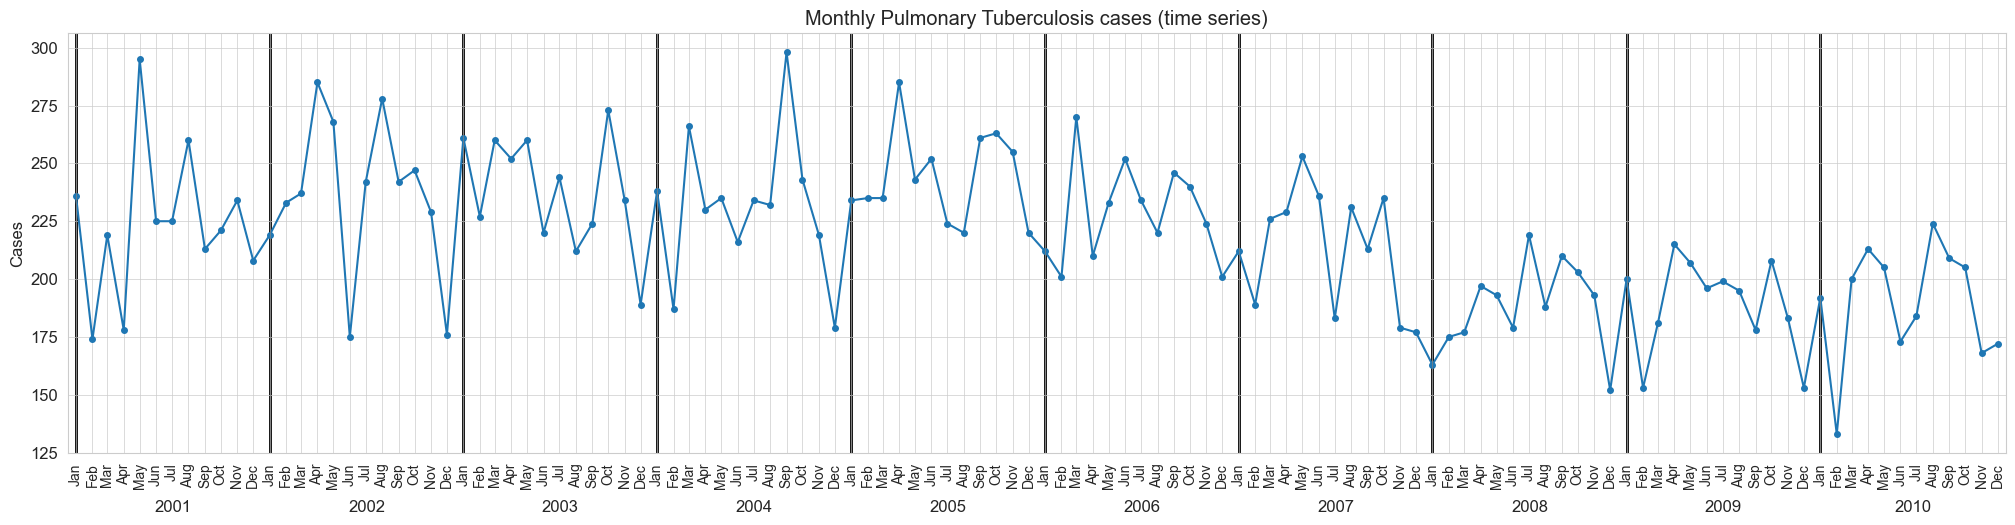

In [5]:
# EN: Plot monthly time series (line) and save figure
# PT-BR: Plot da série mensal (linha) e salvar figura

locale.setlocale(locale.LC_TIME, "en_US.UTF-8")

fig, ax = plt.subplots(figsize=(25,6))

# --- 1. Plotting and Axis Limits ---
ax.plot(series.index, series.values, marker='o', linestyle='-', markersize=4)

ax.set_title("Monthly Pulmonary Tuberculosis cases (time series)")
# ax.set_xlabel is omitted since custom year labels are created below.
ax.set_ylabel("Cases")

# Sets X-axis limits with a small padding (15 days) before the first and after the last data point.
data_inicio_com_margem = series.index[0] - timedelta(days=15)
data_fim_com_margem = series.index[-1] + timedelta(days=15)
ax.set_xlim(data_inicio_com_margem, data_fim_com_margem)

# --- 2. Month Labels (Major Ticks) ---
# Locates a major tick at the start of every month.
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# Formats the major tick to show the abbreviated month name (Jan, Feb...).
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# Rotates the month labels for better readability.
plt.xticks(rotation=90, fontsize=10)


# --- 3. Year Demarcation (Thick Grid Lines) ---
years = np.unique(series.index.year)
# Loop through each year to draw the vertical separation lines.
for y in years:
    start_of_year = datetime(y, 1, 1)
    # Draws a thick vertical line at the beginning of each year.
    ax.axvline(start_of_year, color='black', linewidth=2, zorder=0)


# --- 4. Centered Year Labels ---
ymin, ymax = ax.get_ylim()
# Defines the vertical position for the year label (7% below the minimum Y-axis value).
y_text = ymin - (ymax - ymin) * 0.07

for y in years:
    start = datetime(y, 1, 1)
    # Defines the end of the current year block (start of the next year or end of series).
    if y == years[-1]:
        # For the last year, define the end based on the last data point plus padding.
        end = series.index[-1] + timedelta(days=16)
    else:
        end = datetime(y+1, 1, 1)
        
    # Calculates the horizontal center point of the year block.
    center = start + (end - start) / 2
    
    # Places the year label centered horizontally in the block.
    # The "\n" adds a line break below the month labels.
    ax.text(center, y_text, str("\n" + str(y)), ha='center', va='top', fontsize=12)

# --- 5. Grid and Final Layout Adjustments ---
# Draws the general grid lines (using major ticks as reference).
ax.grid(True, which='major', linestyle='-', linewidth=0.5)

# Draws thinner grid lines for all years (this is a redundant step as axvline covers it).
for y in years:
    start_of_year = datetime(y, 1, 1)
    # Draws a simple vertical line for general grid (optional, as thick lines are already in place).
    ax.axvline(start_of_year, color='grey', linewidth=0.5)

# Adjusts the bottom margin to accommodate the rotated month labels and the centered year labels.
plt.subplots_adjust(bottom=0.18)

# --- 6. Saving and Display ---
fig_path = FIG_DIR / "ts_monthly_cases_line_excel_style.png"
fig.savefig(fig_path, bbox_inches="tight", dpi=150)
print(f"Saved time series plot to {fig_path}")

plt.show()

Generate **boxplots**, from jan to dec yearly, for **seasonality investigation**.

Related questions:
- Does the series have a recurring **seasonal pattern**?
- What is the **dispersion and median** of cases in each month of the year?
- Where are the largest **outliers** relative to each seasonal period?

[DEBUG] Saved month-wise boxplot to figures\boxplot_month_by_month.png


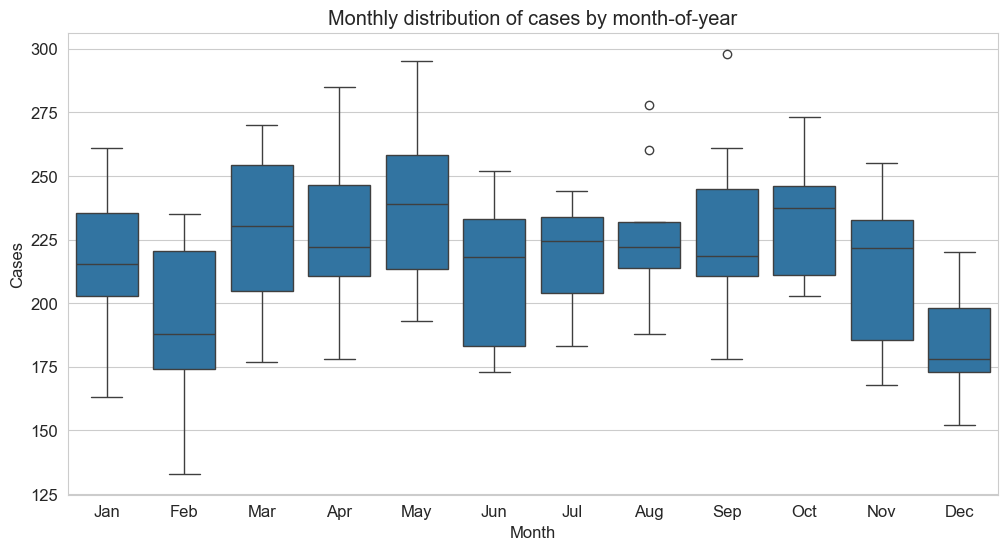

In [6]:
# EN: Boxplot by month to spot seasonality (month-of-year)
# PT-BR: Boxplot por mês para identificar sazonalidade (mês do ano)

df_monthly_plot = df_monthly.reset_index()

# Extracts the numeric month (1 to 12) from the date column for plotting purposes.
df_monthly_plot["month_num"] = df_monthly_plot["date"].dt.month
# Defines the explicit order for the months (1 through 12) to ensure chronological display.
month_order = list(range(1,13))

# Generates the boxplot: X-axis is the month number, Y-axis is the case count.
plt.figure(figsize=(12,6))
sns.boxplot(x="month_num", y="cases", data=df_monthly_plot, order=month_order)
plt.title("Monthly distribution of cases by month-of-year")
plt.xlabel("Month")
plt.ylabel("Cases")
plt.xticks(ticks=np.arange(12), labels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

# Saves the figure to the specified file path.
box_path = FIG_DIR / "boxplot_month_by_month.png"
plt.savefig(box_path, bbox_inches="tight", dpi=150)
debug(f"Saved month-wise boxplot to {box_path}", f"Boxplot mensal salvo em {box_path}")
plt.show()

Generate **heatmaps** (month x year), from 2001-jan to 2010-dec, for **pattern visualization**.

Related questions:
- How is the series' **value distributed** across the Month vs. Year axes?
- Is the **seasonality consistent** over the years, or has it intensified/softened over time?

[DEBUG] Saved heatmap to figures\heatmap_year_month_cases.png


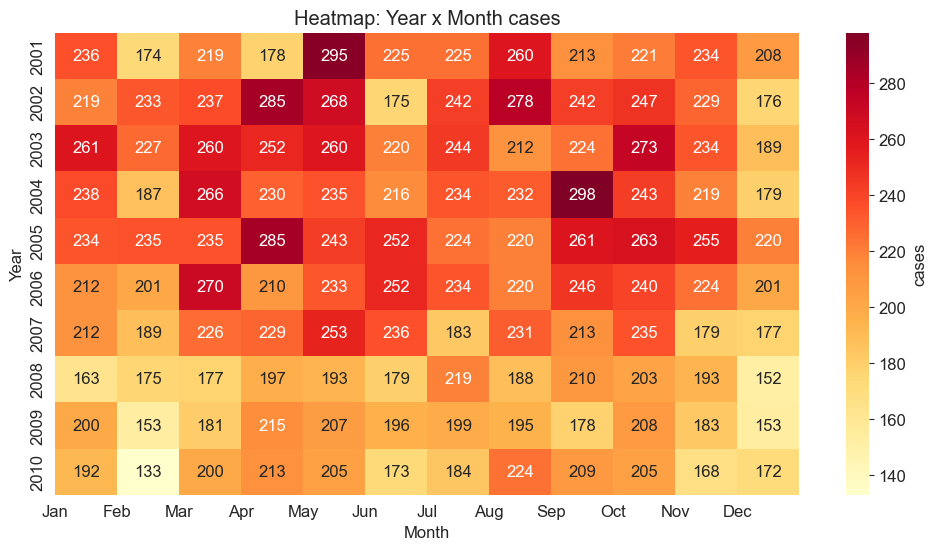

[DEBUG] Saved pivot table year-month to tables.


In [15]:
# EN: Heatmap (years x months) to visualize patterns across years and months
# PT-BR: Heatmap (anos x meses) para visualizar padrões ao longo dos anos e meses

# --- 1. Data Preparation (Pivot Table) ---
# Creates a pivot table to structure the data for the heatmap.
# Index (rows) are the years, columns are the months, and values are the total 'cases'.
pivot = df_monthly_plot.pivot_table(index=df_monthly_plot["date"].dt.year, 
                                    columns=df_monthly_plot["date"].dt.month, 
                                    values="cases", 
                                    aggfunc="sum")
# Reorders the columns to ensure they are sorted chronologically (Jan to Dec).
pivot = pivot.reindex(index=sorted(pivot.index), columns=month_order)

# --- 2. Heatmap Generation ---
plt.figure(figsize=(12,6))
# Generates the heatmap using the pivot table.
sns.heatmap(pivot, 
            annot=True,              # Annotate each cell with its value.
            fmt=".0f",               # Format the annotation as integers (no decimals).
            cmap="YlOrRd",           # Sets the color map (Yellow-Orange-Red, suitable for intensity).
            cbar_kws={'label':'cases'}) # Labels the color bar.
            
# Plot
plt.title("Heatmap: Year x Month cases")
plt.xlabel("Month")
plt.ylabel("Year")
plt.xticks(ticks=np.arange(12), labels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

# --- 3. Saving and Output ---
heat_path = FIG_DIR / "heatmap_year_month_cases.png"
plt.savefig(heat_path, bbox_inches="tight", dpi=150)
debug(f"Saved heatmap to {heat_path}", f"Heatmap salvo em {heat_path}")
plt.show()
pivot.to_csv(TAB_DIR / "pivot_year_month_cases.csv")
debug("Saved pivot table year-month to tables.", "Pivot ano-mes salvo em tables.")

Calculate and **plot the histogram for frequency distribution** visualization.

Related questions:
- What is the **frequency distribution** of the values in the series?
- Does the data follow a **normal distribution** (bell curve)?
- What is the **smooth shape** of the frequency distribution?
- What is the most likely value (**mode**) of the data?

[DEBUG] Saved histogram to figures\histogram_monthly_cases.png


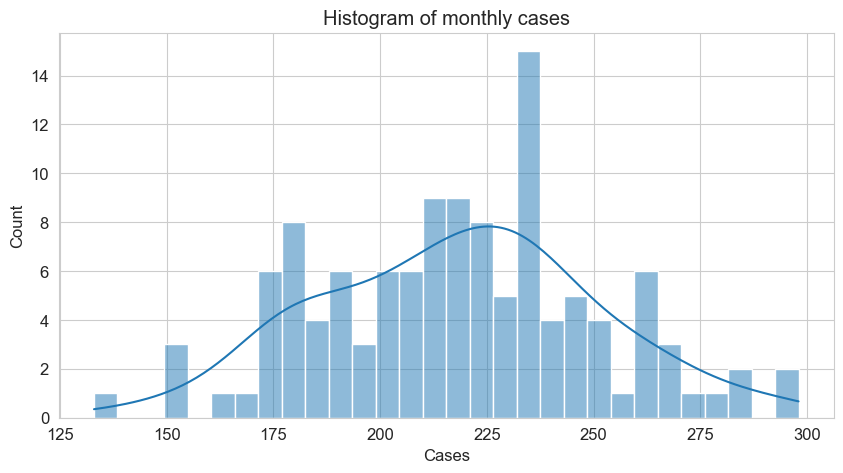

In [17]:
# EN: Histogram and KDE for monthly counts
# PT-BR: Histograma e KDE para contagem mensal

# Generates the histogram plot.
# 'series.dropna()' ensures only valid case counts are used.
# 'kde=True' adds the Kernel Density Estimate line to show the smooth distribution shape.
# 'bins=30' specifies that the data range should be divided into 30 intervals (bars).
plt.figure(figsize=(10,5))
sns.histplot(series.dropna(), kde=True, bins=30)
plt.title("Histogram of monthly cases")
plt.xlabel("Cases")

# Saves the figure. 'bbox_inches="tight"' prevents labels from being cut off.
hist_path = FIG_DIR / "histogram_monthly_cases.png"
plt.savefig(hist_path, bbox_inches="tight", dpi=150)
debug(f"Saved histogram to {hist_path}", f"Histograma salvo em {hist_path}")
plt.show()

### Step 6: **Data Analysis**

**Decomposes the time series** to analyze the data's fundamental structure and **verify the presence of trend and seasonal patterns**.

Related questions:
- What is the **underlying level** of the series, excluding fluctuations (Trend)?
- What is the exact, **repetitive variation** that occurs in each cycle (Seasonality)?
- What **remains** in the series after removing the Trend and Seasonality (Residual)?

[DEBUG] Saved STL decomposition to figures\stl_decomposition.png


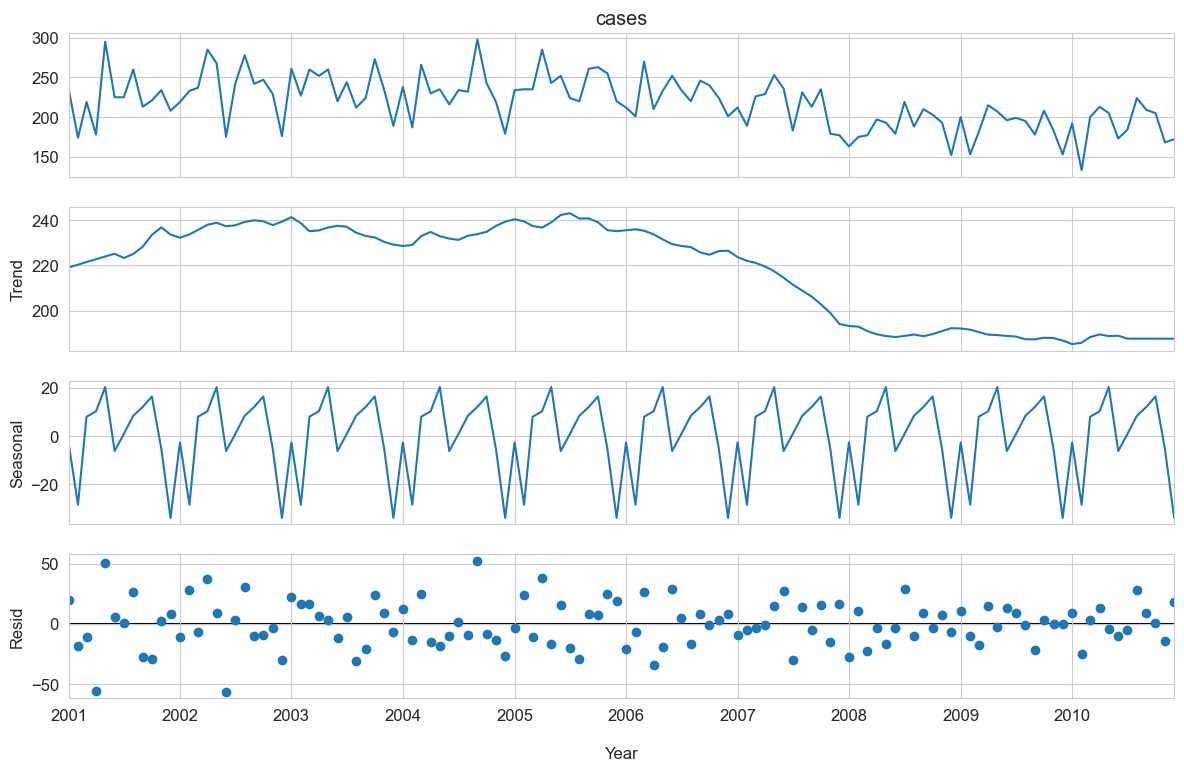

In [20]:
# EN: STL decomposition (trend, seasonal, resid). Period=12 for monthly seasonality.
# PT-BR: Decomposição STL (tendência, sazonal, resíduo). Período=12 para sazonalidade mensal.

try:
    # --- Time Series Decomposition ---
    # Breaks down the time series into its core components (Trend, Seasonality, and Residual)
    # to understand the underlying structure of the data.
    decomposition = seasonal_decompose(series.dropna(), 
                                       model='additive',       # Assumes components are summed: Y = Trend + Seasonality + Residual.
                                       period=12,              # Sets the seasonal cycle length to 12 (as data is monthly, this represents the annual cycle).
                                       extrapolate_trend='freq') # Extrapolates the trend line to the edges of the series.
    
    # --- Plotting ---
    fig = decomposition.plot()
    fig.set_size_inches(12,8)
    plt.xlabel("\nYear")

    # --- Saving ---
    stl_path = FIG_DIR / "stl_decomposition.png"
    fig.savefig(stl_path, bbox_inches="tight", dpi=150)
    debug(f"Saved STL decomposition to {stl_path}", f"Decomposição STL salva em {stl_path}")
    plt.show()
# --- Error Handling ---
except Exception as e:
    # Analytical Note: The decomposition fails if there are not enough data points (less than two full cycles) 
    # or if the data still contains NaN values, leading to an exception.
    debug(f"STL decomposition failed: {e}", f"Decomposição STL falhou: {e}")
    print("STL decomposition failed — likely too few data points or NaNs. / Falha na decomposição STL — provavelmente poucos pontos ou NaNs.")

Calculates and **plots the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACP)** of the time series.

Related questions:
- Does the series have a **correlation with its own past** values?
- What is the **total reach** (direct and indirect) of this correlation?
- What is the direct, **pure correlation** between the current value and a specific lag, isolating the influence of intermediate lags?

[DEBUG] Saved ACF plot to figures\acf_monthly.png


<Figure size 1200x400 with 0 Axes>

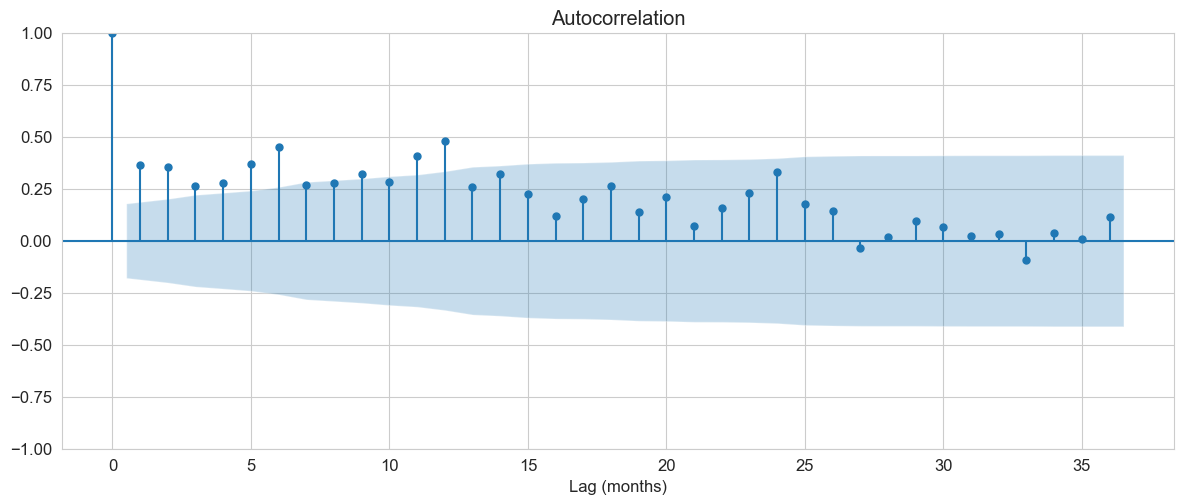

[DEBUG] Saved PACF plot to figures\pacf_monthly.png


<Figure size 1200x400 with 0 Axes>

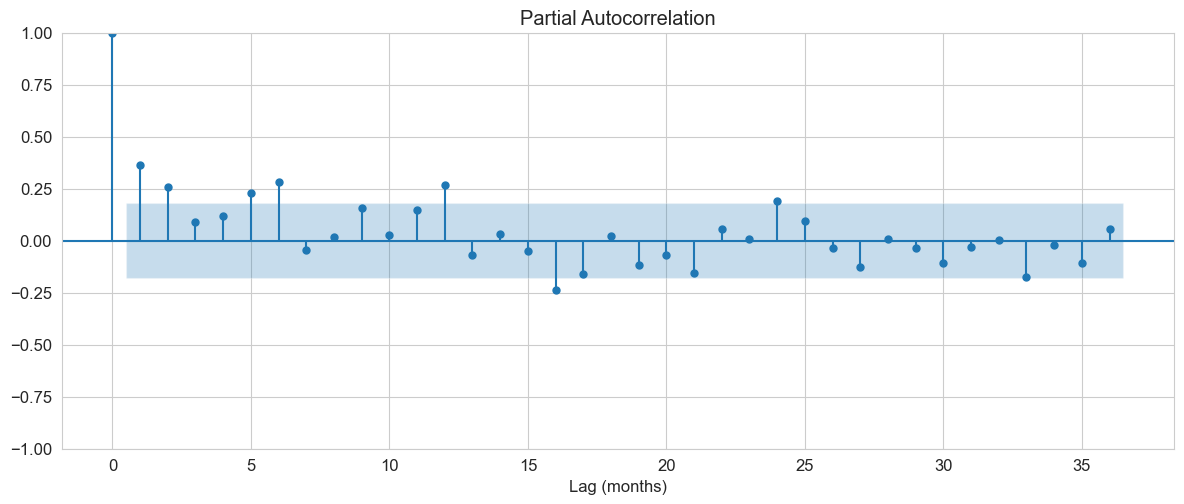

In [26]:
# EN: Plot ACF and PACF to inspect autocorrelation and help choose ARIMA orders
# PT-BR: Plot ACF e PACF para inspecionar autocorrelação e ajudar a escolher ordens ARIMA

# --- 1. Autocorrelation Function (ACF) Plot ---
plt.figure(figsize=(12,4))
# Generates the ACF plot: measures the total correlation between the series (Yt) and its past values (Yt-k).
# series.dropna(): Ensures clean data is used for correlation calculation.
# lags=36: Analyzes correlation up to 36 months (3 years) into the past.
# Purpose: The plot visually identifies the correlation structure of the series, indicating the order of the 
# Moving Average (MA) component, or 'q', in an ARIMA model (where the ACF cuts off or decays).
plot_acf(series.dropna(), lags=36)
plt.tight_layout()
plt.xlabel("Lag (months)")
acf_path = FIG_DIR / "acf_monthly.png"
plt.savefig(acf_path, bbox_inches="tight", dpi=150)
debug(f"Saved ACF plot to {acf_path}", f"ACF salvo em {acf_path}")
plt.show()

# --- 2. Partial Autocorrelation Function (PACF) Plot ---
plt.figure(figsize=(12,4))
# Generates the PACF plot: measures the pure, direct correlation between the series (Yt) and a specific lag (Yt-k), 
# after removing the influence of all intermediate lags (Yt-1, ..., Yt-k+1).
# lags=36: Analyzes direct correlation up to 36 months into the past.
# method='ywm': Uses the Yule-Walker method for PACF calculation, which is robust.
# Purpose: The plot is used to identify the order of the Autoregressive (AR) component, or 'p', in an ARIMA model 
# (where the PACF cuts off or decays).
plot_pacf(series.dropna(), lags=36, method='ywm')
plt.tight_layout()
plt.xlabel("Lag (months)")
pacf_path = FIG_DIR / "pacf_monthly.png"
plt.savefig(pacf_path, bbox_inches="tight", dpi=150)
debug(f"Saved PACF plot to {pacf_path}", f"PACF salvo em {pacf_path}")
plt.show()

**Aggregates the monthly data** into a yearly summary table to calculate the percentage change, allowing for analysis of long-term trends and growth/decline rates.

In [11]:
# EN: Yearly aggregated table and year-on-year percent change
# PT-BR: Tabela agregada anual e variação percentual ano-a-ano

if "cases" in df_annual.columns:
    df_annual_sorted = df_annual.sort_values("year").copy()
else:
    # fallback: aggregate from monthly
    df_annual_sorted = df_monthly_plot.groupby(df_monthly_plot["date"].dt.year)["cases"].sum().reset_index().rename(columns={"date":"year"})

df_annual_sorted["pct_change"] = df_annual_sorted["cases"].pct_change() * 100
display(df_annual_sorted)
df_annual_sorted.to_csv(TAB_DIR / "annual_summary_cases_pctchange.csv", index=False)
debug("Saved annual summary table.", "Resumo anual salvo.")

,year,cases,population,incidence_per_100k,pct_change
0,2001,50266,NaN,NaN,NaN
1,2002,395140,NaN,NaN,686.097959
2,2003,501459,NaN,NaN,26.906666
3,2004,469697,NaN,NaN,-6.333918
4,2005,516799,NaN,NaN,10.028167
5,2006,459628,NaN,NaN,-11.062521
6,2007,693293,NaN,NaN,50.837851
7,2008,403975,NaN,NaN,-41.730985
8,2009,311683,NaN,NaN,-22.845968
9,2010,331407,NaN,NaN,6.328225


[DEBUG] Saved annual summary table.


### EDA Output

**Saves the EDA results** for later use.

In [12]:
# EN: Save compact EDA summary for later use (quick tables)
# PT-BR: Salvar um resumo EDA compacto para uso posterior

# Monthly seasonal means
seasonal_means = df_monthly_plot.groupby(df_monthly_plot["date"].dt.month)["cases"].mean().rename_axis("month").reset_index()
seasonal_means["month_name"] = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
seasonal_means.to_csv(TAB_DIR / "monthly_seasonal_means.csv", index=False)

# Top months (highest counts)
top_months = df_monthly_plot.sort_values("cases", ascending=False).head(20)
top_months.to_csv(TAB_DIR / "top_20_months_by_cases.csv", index=False)

debug("Saved seasonal means and top months tables.", "Salvo médias sazonais e top meses.")

[DEBUG] Saved seasonal means and top months tables.


**List** the generated files.

In [13]:
# EN: Optional - list generated files
# PT-BR: Opcional - listar arquivos gerados

print("Figures saved to:", FIG_DIR.resolve())
print("Tables saved to:", TAB_DIR.resolve())
print("Files in figures (example):", [p.name for p in sorted(FIG_DIR.glob("*.png"))][:10])
print("Files in tables (example):", [p.name for p in sorted(TAB_DIR.glob("*.csv"))][:20])

Figures saved to: D:\OneDrive\Arquivos\Pessoais\Desenvolvimento\Ciência de Dados\IC2011 - TB MA\figures
Tables saved to: D:\OneDrive\Arquivos\Pessoais\Desenvolvimento\Ciência de Dados\IC2011 - TB MA\tables
Files in figures (example): ['acf_for_model.png', 'acf_monthly.png', 'boxplot_month_by_month.png', 'heatmap_year_month_cases.png', 'histogram_monthly_cases.png', 'history_plus_forecast_2011.png', 'model_predictions_vs_actual_2010.png', 'pacf_for_model.png', 'pacf_monthly.png', 'stl_decomposition.png']
Files in tables (example): ['annual_summary_cases_pctchange.csv', 'monthly_seasonal_means.csv', 'monthly_series_descriptive_stats.csv', 'pivot_year_month_cases.csv', 'top_20_months_by_cases.csv']
